# Emotion Recognition using ECG Signals
----------------------------------------------------------------
`Team Number: 02`

----------------------------------------------------------------

`Team Members:`

- `CS20B1016`: V Nagasai
- `EC20B1002`: T Dheeraj
- `EC20B1058`: C Ramasai

----------------------------------------------------------------

## Data Preprocessing and Visualization

In [44]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

#Converting stimulus description xlsx file to csv file
stimulus_desc_file = pd.read_excel('Data/Stimulus_Description.xlsx')
stimulus_desc_file.to_csv('Data/Stimulus_Description.csv', index = None, header=True)
stimulus_desc = pd.read_csv('Data/Stimulus_Description.csv')

#Converting self annotation labels xlsx file to csv file and renaming labels for our convenience for multimodal
self_annotation_multimodal_file = pd.read_excel('Data/Annotated/Multimodal_Use.xlsx')
self_annotation_multimodal_file.to_csv('Data/Multimodal_Use.csv', index = None, header=True)
self_annotation_multimodal = pd.read_csv('Data/Multimodal_Use.csv')
self_annotation_multimodal['annotation'] = 'M' #Annotate as multimodal
self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)

#Converting self annotation labels xlsx file to csv file and renaming labels for our convenience for multimodal
self_annotation_singlemodal_file = pd.read_excel('Data/Annotated/Singlemodal_Use.xlsx')
self_annotation_singlemodal_file.to_csv('Data/Singlemodal_Use.csv', index = None, header=True)
self_annotation_singlemodal = pd.read_csv('Data/Singlemodal_Use.csv')
self_annotation_singlemodal['annotation'] = 'S' #Annotate as single modal
self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)

#Merging the two csv files
self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
merged_df = pd.concat(self_annotation_frames)
table_frame = merged_df.copy()
merged_df.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_M,13,Female,8,0,0,High,...,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M
1,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Sad,LV,LA,LVLA,M
2,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,Low,NaN,Surprise,LV,LA,LVLA,M
3,1,1,4,M_M,13,Female,9,0,0,VeryHigh,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Happy,HV,LA,HVLA,M
4,1,1,5,M_M,13,Female,0,9,0,VeryLow,...,VeryLow,VeryLow,VeryHigh,VeryLow,NaN,Disgust,LV,HA,LVHA,M


# Data extraction

In [45]:
cols = []
cols.append('Raw Data')
for col in merged_df.columns:
    cols.append(col)

arr_shape = 1000
raw_data_arr = []

def form_data(data_array = [], annotation = '', data_path = ''):
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('ECGdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            session = filenames.split('s')[1].split('p')[0]
            participant = filenames.split('p')[1].split('v')[0]
            video = filenames.split('v')[1]
            data_row = merged_df.loc[(merged_df['Session ID'] == int(session)) & 
                             (merged_df['Participant Id'] == int(participant)) & 
                             (merged_df['Video ID'] == int(video)) &
                             (merged_df['annotation'] == 'M')]
            stimulus_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(session)) & 
                             (stimulus_desc['Video ID'] == int(video))]
            for _, row in data_row.iterrows():
              data_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['annotation'],  stimulus_row['Target Emotion'].iat[0]
                                   ])
    return data_array

    
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'M', data_path = "Data/Raw/Multimodal/ECG/")
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'S', data_path = "Data/Raw/Singlemodal/ECG/")
cols.append('Target Emotion')
raw_df = pd.DataFrame(raw_data_arr, columns = cols)
raw_df.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_df['Familiarity Score'] = raw_df['Familiarity Score'].fillna('Never watched')
raw_df = raw_df.replace(np.nan, '', regex=True)

In [46]:
plot_frame = raw_df.copy()
plot_frame = plot_frame.drop(['Participant ID', 'Session ID', 'Familiarity Score', 'Age', 'Gender', 'Name'], axis = 1)
sad_data = plot_frame.loc[(plot_frame['Emotion'] == 'Sad') & (plot_frame['Target Emotion'] == 'sad')] 
fear_data = plot_frame.loc[(plot_frame['Emotion'] == 'Fear')  & (plot_frame['Target Emotion'] == 'fear')]
happy_data = plot_frame.loc[(plot_frame['Emotion'] == 'Happy') & (plot_frame['Target Emotion'] == 'happy')]
anger_data = plot_frame.loc[(plot_frame['Emotion'] == 'Anger') & (plot_frame['Target Emotion'] == 'anger')]
neutral_data = plot_frame.loc[(plot_frame['Emotion'] == 'Neutral') & (plot_frame['Target Emotion'] == 'neutral')]
mixed_data = plot_frame.loc[(plot_frame['Emotion'] == 'Mixed') & (plot_frame['Target Emotion'] == 'neutral')]
disgust_data = plot_frame.loc[(plot_frame['Emotion'] == 'Disgust') & (plot_frame['Target Emotion'] == 'disgust')]
surprised_data = plot_frame.loc[(plot_frame['Emotion'] == 'Surprise') & (plot_frame['Target Emotion'] == 'surprise')]

# Data visualization

In [47]:
#Function to plot signals
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    for _, row in data_arr.iterrows():
        y = row['Raw Data']
        plt.plot(y)
    plt.tight_layout()
    plt.title(title)
    plt.show()

<Figure size 640x480 with 0 Axes>

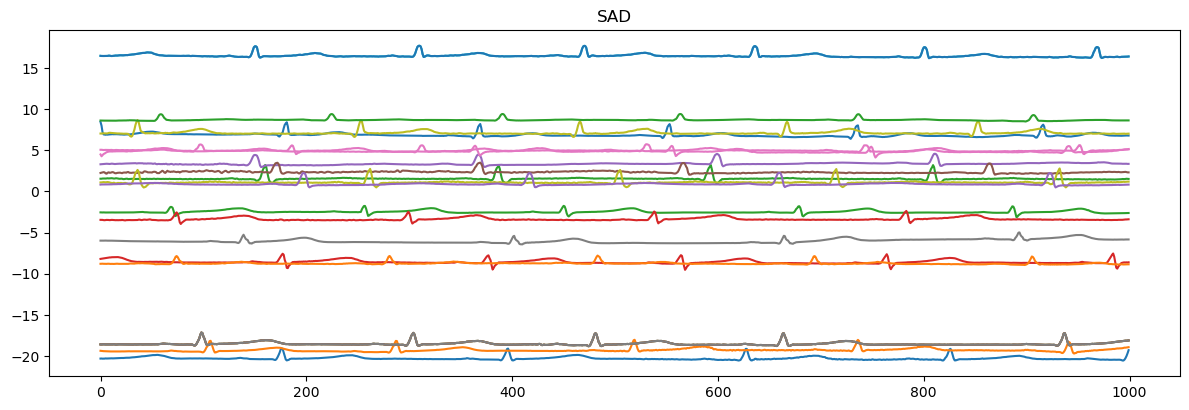

<Figure size 640x480 with 0 Axes>

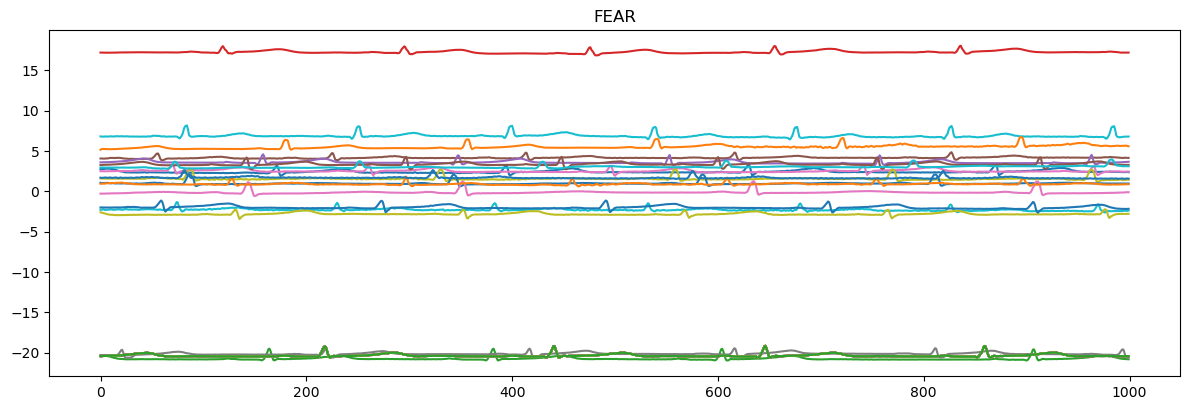

<Figure size 640x480 with 0 Axes>

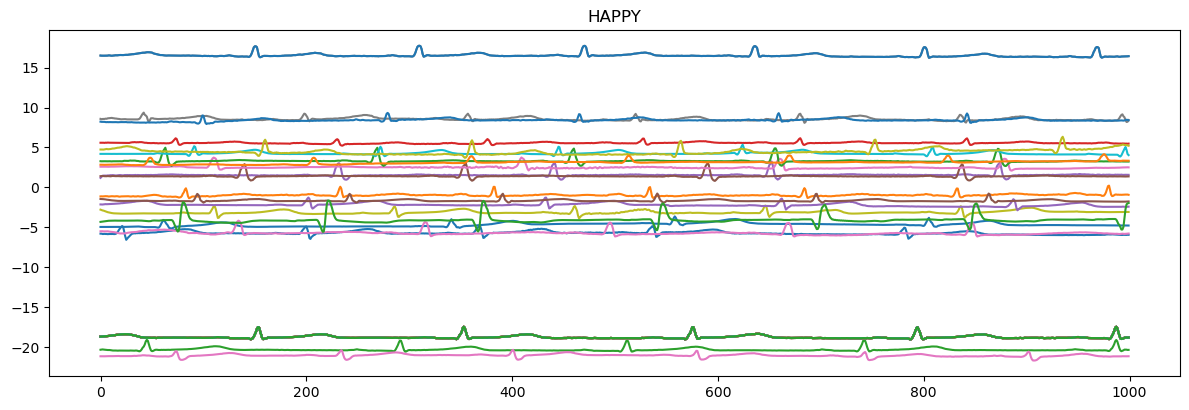

<Figure size 640x480 with 0 Axes>

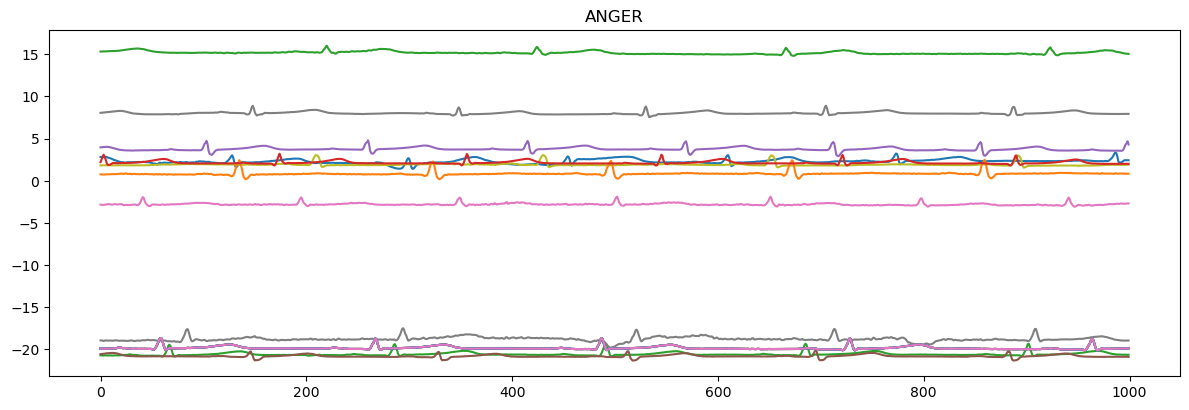

<Figure size 640x480 with 0 Axes>

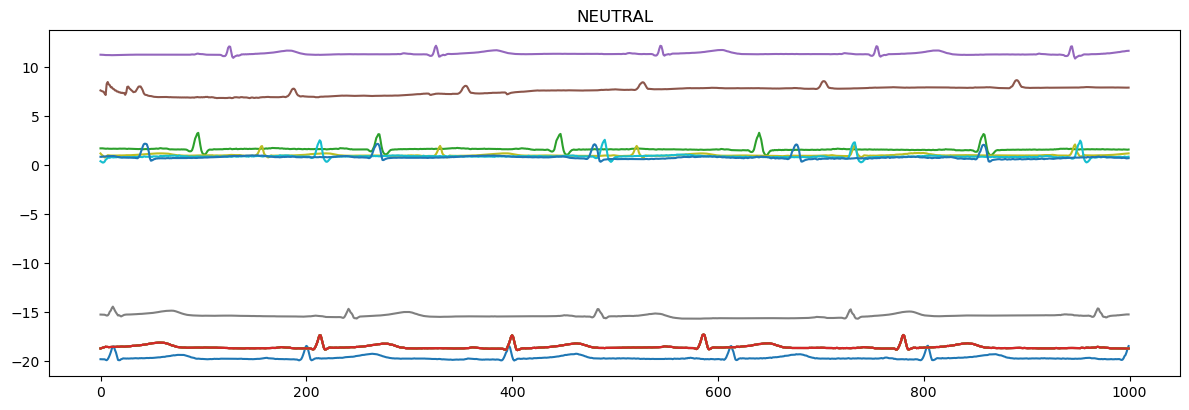

<Figure size 640x480 with 0 Axes>

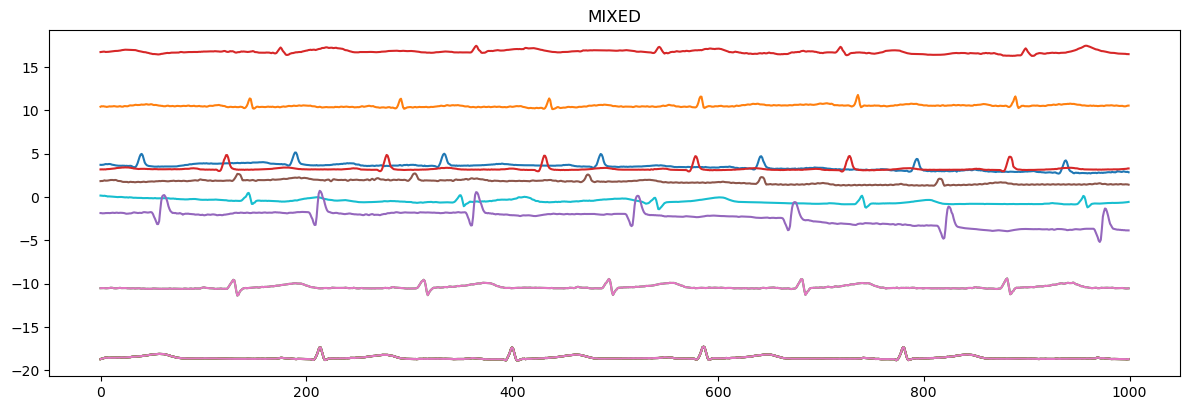

<Figure size 640x480 with 0 Axes>

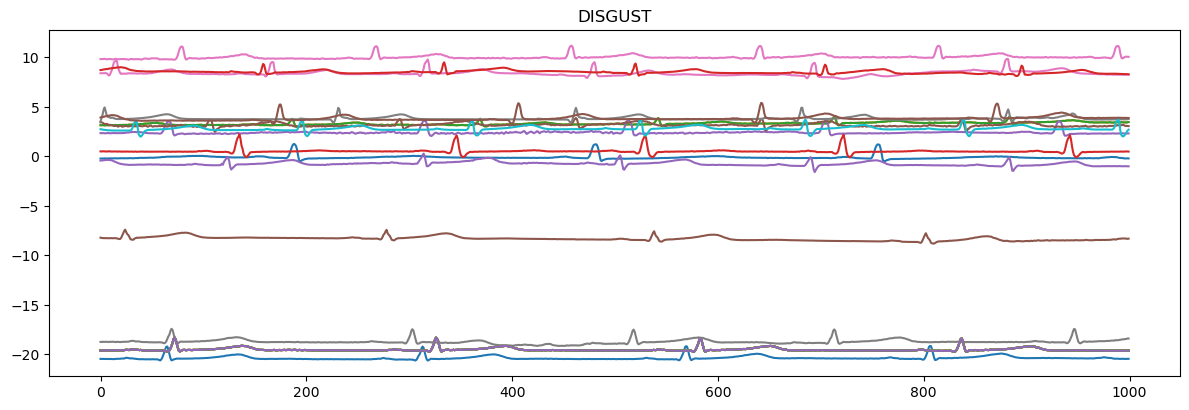

<Figure size 640x480 with 0 Axes>

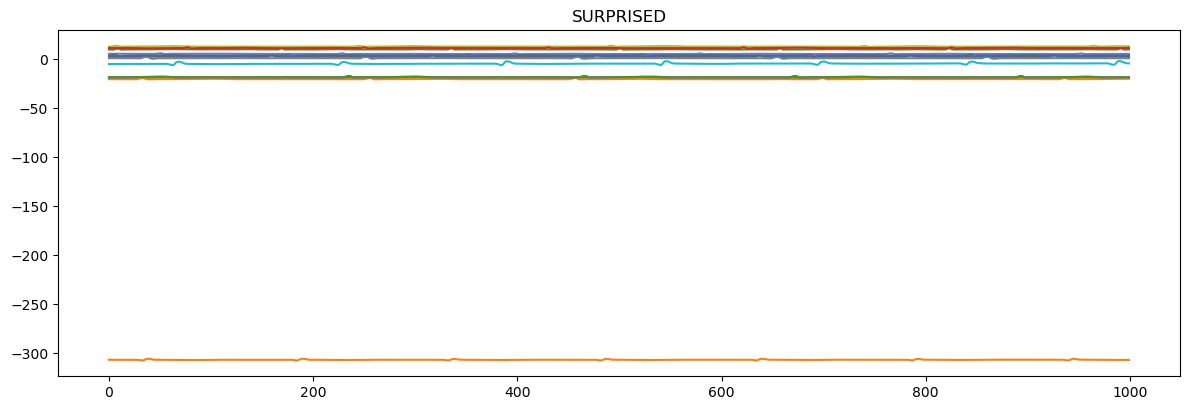

In [48]:
plot_signals(data_arr = sad_data, title = 'SAD')
plot_signals(data_arr = fear_data, title = 'FEAR')
plot_signals(data_arr = happy_data, title = 'HAPPY')
plot_signals(data_arr = anger_data, title = 'ANGER')
plot_signals(data_arr = neutral_data, title = 'NEUTRAL')
plot_signals(data_arr = mixed_data, title = 'MIXED')
plot_signals(data_arr = disgust_data, title = 'DISGUST')
plot_signals(data_arr = surprised_data, title = 'SURPRISED')